# Ground-Truth problems

These are problems for which the data generating process is a known model, 

$$ y = \phi^*(\mathbf{x}, \theta^*) $$

We assess how well symbolic regression algorithms find the form of the model, $\phi^*$, with some leniency on $\theta^*$ (we allow the model to be off by a constant or a scalar). 

You can just skip to point 3 if there is no additional calculation to be done
1. Read srbench data and calculate additional information
2. Read pafam data and convert such that is compatible with srbench data
3. Read finished parfam_data in df_parfam and df_sum
4. Plots:
4.1 Pointplot
4.2 Pairgrid 

This notebook is build upon the code and results from https://github.com/cavalab/srbench

# read data from feather

In [1]:
from tabulate import tabulate
import pandas as pd
import json
import numpy as np
from glob import glob
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rc('pdf', fonttype=42)
import os
sns.set(font_scale=1.2)
rdir = ''
# figdir = 'figs/ground-truth/'
figdir = 'figs/'

print('figdir:',figdir)
def save(h=None,name='tmp'):
    name = name.strip().replace(' ','-').replace('%','pct')
    if h == None:
        h = plt.gcf()
    h.tight_layout()
    print('saving',name+'.pdf')
    if not os.path.exists(figdir):
        os.makedirs(figdir)
    plt.savefig(figdir+'/'+name+'.pdf', dpi=400, bbox_inches='tight')
    

figdir: figs/


# 1. Compute results in df_sum

In [2]:
df_results = pd.read_feather(rdir+'ground-truth_results.feather')

In [3]:
df_results.columns

Index(['dataset', 'algorithm', 'random_state', 'process_time',
       'training time (s)', 'target_noise', 'feature_noise', 'true_model',
       'model_size', 'symbolic_model', 'mse_train', 'mae_train', 'r2_train',
       'mse_test', 'mae_test', 'r2_test', 'simplified_symbolic_model',
       'simplified_complexity', 'symbolic_error', 'symbolic_fraction',
       'symbolic_error_is_zero', 'symbolic_error_is_constant',
       'symbolic_fraction_is_constant', 'sympy_exception',
       'training time (hr)', 'r2_zero_test', 'data_group',
       'symbolic_solution'],
      dtype='object')

### compute symbolic solutions

In [4]:
df_results.loc[:,'symbolic_solution'] = df_results[['symbolic_error_is_zero',
                                                    'symbolic_error_is_constant',
                                                    'symbolic_fraction_is_constant']
                                                   ].apply(any,raw=True, axis=1)
# clean up any corner cases (constant models, failures)
df_results.loc[:,'symbolic_solution'] = df_results['symbolic_solution'] & ~df_results['simplified_symbolic_model'].isna() 
df_results.loc[:,'symbolic_solution'] = df_results['symbolic_solution'] & ~(df_results['simplified_symbolic_model'] == '0')
df_results.loc[:,'symbolic_solution'] = df_results['symbolic_solution'] & ~(df_results['simplified_symbolic_model'] == 'nan')

# save results for detailed tabulating
df_results.to_feather(rdir+'ground-truth_solns.feather')

### summarize results by dataset, including ranking

In [5]:
df_results2 = df_results.merge(df_results.groupby(['dataset','target_noise'])['algorithm'].nunique().reset_index(),
                              on=['dataset','target_noise'],suffixes=('','_count'))
df_results2 = df_results2.drop(['true_model','symbolic_model','simplified_symbolic_model','symbolic_fraction','symbolic_error'],axis=1)
# count repeat trials
df_results2 = df_results2.merge(df_results2.groupby(['algorithm','dataset','target_noise'])['random_state'].nunique().reset_index(),
                                on=['algorithm','dataset','target_noise'],
                                suffixes=('','_repeats'))
# accuracy-based exact solutions 
df_results2['accuracy_solution'] = df_results2['r2_test'].apply(lambda x: x > 0.999).astype(float)

# get mean solution rates for algs on datasets at specific noise levels, averaged over trials 
for soln in ['accuracy_solution','symbolic_solution']:
    df_results2 = df_results2.merge(
        df_results2.groupby(['algorithm','dataset','target_noise'])[soln].mean().reset_index(),
                                  on=['algorithm','dataset', 'target_noise'],suffixes=('','_rate'))

In [6]:
# rankings
for col in [c for c in df_results2.columns if c.endswith('test') or c.endswith('size')]:
    ascending = 'r2' not in col
    df_results2[col+'_rank_per_trial']=df_results2.groupby(
        ['dataset','target_noise','random_state'])[col].apply(
        lambda x:round(x,3).rank(ascending=ascending).astype(int)).reset_index(drop=True) #changed this code
    #got error incompatible index of inserted column with frame index

/home/philipp/anaconda3/envs/srbench/lib/python3.10/site-packages/pandas/core/series.py:2442: RuntimeWarning: overflow encountered in multiply
  result = self._values.round(decimals)


In [7]:
col = df_results2.columns.drop(['sympy_exception'])
df_sum = df_results2[col].groupby(['algorithm','dataset','target_noise','data_group'],as_index=False).median()

In [8]:
# rankings
for col in [c for c in df_results2.columns if c.endswith('test') or c.endswith('size')]:
    ascending = 'r2' not in col
    df_results2[col+'_rank_per_trial']=df_results2.groupby(
        ['dataset','target_noise','random_state'])[col].apply(
        lambda x:round(x,3).rank(ascending=ascending).astype(int)).reset_index(drop=True) #changed this code
    #got error incompatible index of inserted column with frame index


/home/philipp/anaconda3/envs/srbench/lib/python3.10/site-packages/pandas/core/series.py:2442: RuntimeWarning: overflow encountered in multiply
  result = self._values.round(decimals)


In [9]:
# rankings and normalized scores per dataset
for col in [c for c in df_sum.columns if any([c.endswith(n) for n in ['test','size','rate']])]:
    ascending = 'r2' not in col and 'solution' not in col
    df_sum[col+'_rank']=df_sum.groupby(['dataset','target_noise'])[col].apply(
        lambda x:  round(x,3).rank(ascending=ascending).astype(int) ).reset_index(drop=True)
    df_sum[col+'_norm'] = df_sum.groupby(['dataset','target_noise'])[col].apply(lambda x: (x-x.min())/(x.max()-x.min())).reset_index(drop=True)

In [10]:
for soln in ['accuracy_solution','symbolic_solution']:
    df_sum[soln +'_rate_(%)'] = df_sum[soln+'_rate'].apply(lambda x: x*100)
df_sum['rmse_test'] = df_sum['mse_test'].apply(np.sqrt)
df_sum['log_mse_test'] = df_sum['mse_test'].apply(lambda x: np.log(1+x))
df_results = df_results2
#df_sum

# save summary data
used for statistical comparisons

In [11]:
df_sum.to_csv(rdir+'symbolic_dataset_results_sum.csv.gz',compression='gzip', index=False)

In [12]:
df_sum = pd.read_csv('symbolic_dataset_results_sum.csv.gz', compression='gzip')

In [13]:
df_sum.columns

Index(['algorithm', 'dataset', 'target_noise', 'data_group', 'random_state',
       'process_time', 'training time (s)', 'feature_noise', 'model_size',
       'mse_train', 'mae_train', 'r2_train', 'mse_test', 'mae_test', 'r2_test',
       'simplified_complexity', 'symbolic_error_is_zero',
       'symbolic_error_is_constant', 'symbolic_fraction_is_constant',
       'training time (hr)', 'r2_zero_test', 'symbolic_solution',
       'algorithm_count', 'random_state_repeats', 'accuracy_solution',
       'accuracy_solution_rate', 'symbolic_solution_rate',
       'model_size_rank_per_trial', 'mse_test_rank_per_trial',
       'mae_test_rank_per_trial', 'r2_test_rank_per_trial',
       'r2_zero_test_rank_per_trial', 'model_size_rank', 'model_size_norm',
       'mse_test_rank', 'mse_test_norm', 'mae_test_rank', 'mae_test_norm',
       'r2_test_rank', 'r2_test_norm', 'r2_zero_test_rank',
       'r2_zero_test_norm', 'accuracy_solution_rate_rank',
       'accuracy_solution_rate_norm', 'symbolic_sol

# 2. Change ParFam Data 

In [16]:
df_parfam = pd.read_csv("../Without noise/results_analyzed.csv")
df_noise = pd.read_csv("../With noise/results_analyzed.csv")
df_parfam = pd.concat([df_parfam, df_noise], ignore_index=True)
df_parfam

,Unnamed: 0.1,Unnamed: 0,Index,max_deg_input,max_deg_output,max_deg_input_denominator,max_deg_output_denominator,max_deg_output_polynomials_specific,max_deg_output_polynomials_denominator_specific,width,...,r_squared_val_reduced,best_formula_reduced,n_evaluations,r_squared_test_final,n_active_coefficients_final,estimated_formula_final,symbolic_recovery_final,accuracy_solution_final,complexity_final,simplified_formulas
0,0.0,1.0,120,2,4,2,3,"[1, 1, 1]","[1, 1, 1]",1,...,1.000000,1.775*x0*sqrt(Abs(0.317*x1**2 + 0.317*x2**2 + ...,150085,1.000000,4,1.775*x0*sqrt(Abs(0.317*x1**2 + 0.317*x2**2 + ...,True,True,15,NaN
1,1.0,5.0,121,2,4,2,3,"[1, 1, 1]","[1, 1, 1]",1,...,1.000000,0.159*x0*x1,3865,1.000000,1,0.159*x0*x1,True,True,4,NaN
2,2.0,8.0,122,2,4,2,3,"[1, 1, 1]","[1, 1, 1]",1,...,1.000000,12.566*x0*x1**2*x2/x3,15969,1.000000,2,12.566*x0*x1**2*x2/x3,True,True,8,NaN
3,3.0,13.0,123,2,4,2,3,"[1, 1, 1]","[1, 1, 1]",1,...,0.999998,0.002*x0**2*x1**2 - 0.002*x0**2*x1*exp((-0.002...,543008,0.999998,77,0.002*x0**2*x1**2 - 0.002*x0**2*x1*exp((-0.002...,False,True,421,NaN
4,4.0,18.0,124,2,4,2,3,"[1, 1, 1]","[1, 1, 1]",1,...,1.000000,-2.0*x0*cos(1.0*x1*x2 - 6.283) + 2.0*x0,220902,1.000000,5,-2.0*x0*cos(1.0*x1*x2 - 6.283) + 2.0*x0,True,True,14,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
261,NaN,NaN,250,2,4,2,3,"[1, 1, 1]","[1, 1, 1]",1,...,0.999925,(-0.053*x0*x1**2 + 0.708*x0*x1 - 0.053*x1**2)/...,9732,0.999998,5,(-0.053*x0*x1**2 + 0.708*x0*x1 - 0.053*x1**2)/...,True,True,20,x1*(-0.053*x0*x1 + 0.708*x0 - 0.053*x1)/(0.709...
262,NaN,NaN,251,2,4,2,3,"[1, 1, 1]","[1, 1, 1]",1,...,0.999933,(-0.091*x0**3*x1 + 0.0217060000480996*x0**3*ex...,998048,0.999341,38,(-0.091*x0**3*x1 + 0.0217060000480996*x0**3*ex...,False,True,163,(-0.091*x0**3*x1 + 0.0217060000480996*x0**3*ex...
263,NaN,NaN,252,2,4,2,3,"[1, 1, 1]","[1, 1, 1]",1,...,0.999848,(0.074*x0**3*x1 - 0.118*x0**3*sqrt(Abs((0.059*...,999458,0.998884,44,(0.074*x0**3*x1 - 0.118*x0**3*sqrt(Abs((0.059*...,False,False,181,(0.074*x0**3*x1 - 0.118*x0**3*sqrt(Abs((0.059*...
264,NaN,NaN,253,2,4,2,3,"[1, 1, 1]","[1, 1, 1]",1,...,0.999879,-3.315*x0**3 - 0.052*x0**2*x1 + 0.001*x0**2 + ...,1372,0.999996,13,-3.326*x0**3 - 0.025*x0**2*x1 - 0.005*x0**2 + ...,True,True,34,-3.326*x0**3 - 0.025*x0**2*x1 - 0.005*x0**2 + ...


### Get only all iter values with maxiter1 = 100

In [17]:
# mask = df_parfam["maxiter1"]==100
# df_parfam = df_parfam[mask]

# Drop all duplicates and keep the first occurrence
# df_parfam = df_parfam.drop_duplicates(subset=["dataset","target_noise"],keep='last')

df_parfam = df_parfam.drop(['max_deg_input', 'max_deg_output',
       'max_deg_input_denominator', 'max_deg_output_denominator',
       'max_deg_output_polynomials_specific',
       'max_deg_output_polynomials_denominator_specific', 'width',
       'function_names', 'maximal_potence', 'maxiter2',
        'optimizer', 'classifier',
       'local_minimizer', 'pruning_iterations', 'pruning_cut_off',
       'maxiter_per_dim_local_minimizer', 'max_dataset_length', 'lambda_1',
       'repetitions', 'parallel', 'n_processes', 'lambda_1_cut',
       'lambda_1_piecewise', 'device'],axis=1)

In [18]:
print(df_parfam.columns)
df_sum.columns

Index(['Unnamed: 0.1', 'Unnamed: 0', 'Index', 'maximal_n_functions',
       'maxiter1', 'target_noise', 'feature_noise', 'accuracy', 'time_limit',
       'evaluations_limit', 'iterative_finetuning', 'max_n_active_parameters',
       'dataset', 'target_formula', 'estimated_formula', 'relative_l2_train',
       'relative_l2_val', 'relative_l2_test', 'r_squared_val',
       'r_squared_test', 'success', 'training_time', 'n_active_coefficients',
       'n_active_coefficients_reduced', 'relative_l2_distance_test_reduced',
       'r_squared_test_reduced', 'r_squared_val_reduced',
       'best_formula_reduced', 'n_evaluations', 'r_squared_test_final',
       'n_active_coefficients_final', 'estimated_formula_final',
       'symbolic_recovery_final', 'accuracy_solution_final',
       'complexity_final', 'simplified_formulas'],
      dtype='object')


Index(['algorithm', 'dataset', 'target_noise', 'data_group', 'random_state',
       'process_time', 'training time (s)', 'feature_noise', 'model_size',
       'mse_train', 'mae_train', 'r2_train', 'mse_test', 'mae_test', 'r2_test',
       'simplified_complexity', 'symbolic_error_is_zero',
       'symbolic_error_is_constant', 'symbolic_fraction_is_constant',
       'training time (hr)', 'r2_zero_test', 'symbolic_solution',
       'algorithm_count', 'random_state_repeats', 'accuracy_solution',
       'accuracy_solution_rate', 'symbolic_solution_rate',
       'model_size_rank_per_trial', 'mse_test_rank_per_trial',
       'mae_test_rank_per_trial', 'r2_test_rank_per_trial',
       'r2_zero_test_rank_per_trial', 'model_size_rank', 'model_size_norm',
       'mse_test_rank', 'mse_test_norm', 'mae_test_rank', 'mae_test_norm',
       'r2_test_rank', 'r2_test_norm', 'r2_zero_test_rank',
       'r2_zero_test_norm', 'accuracy_solution_rate_rank',
       'accuracy_solution_rate_norm', 'symbolic_sol

In [19]:
#Rename columns_names
new_column_names = {'relative_l2_test': 'mse_test', # not correct, since use the relative (normalized) l2 error, while they use the non normalized squared l2 error
                    'r_squared_test_final': 'r2_test', 
                    'relative_l2_train': 'mse_train',  # same as for relative_l2_test
                    'r_squared_train': 'r2_train',
                    'training_time':'training time (s)',
                     'complexity_final':'model_size',
                    'symbolic_recovery_final':'symbolic_solution'}
df_parfam.rename(columns=new_column_names, inplace=True)

In [20]:
#Add new columns
df_parfam["algorithm"]="ParFam"
df_parfam.loc[df_parfam['dataset'].str.contains('feynman'), "data_group"] = "Feynman"
df_parfam.loc[df_parfam['dataset'].str.contains('strogatz'), "data_group"] = "Strogatz"
df_parfam['training time (hr)'] = df_parfam['training time (s)']/(60*60)
df_parfam['rmse_test']=df_parfam["mse_test"].apply(np.sqrt)
df_parfam['log_mse_test']=df_parfam["mse_test"].apply(lambda x: np.log(1+x))
df_parfam['accuracy_solution'] = df_parfam['r2_test'].apply(lambda x: x > 0.999).astype(float)
#Rankings -> comput later on 
#df_parfam['model_size_rank']=df_parfam.groupby(['dataset','target_noise'])['model_size'].apply(
        #lambda x:  round(x,3).rank(ascending=ascending).astype(int) ).reset_index(drop=True)
#df_parfam['r2_test_rank']=df_parfam.groupby(['dataset','target_noise'])['r2_test'].apply(
        #lambda x:  round(x,3).rank(ascending=ascending).astype(int) ).reset_index(drop=True)

### Group df_parfam in order to get solution rate

In [21]:
# get mean solution rates for algs on datasets at specific noise levels, averaged over trials 
for soln in ['accuracy_solution','symbolic_solution']:
    df_parfam = df_parfam.merge(
        df_parfam.groupby(['algorithm','dataset','target_noise'])[soln].mean().reset_index(),
                                  on=['algorithm','dataset', 'target_noise'],suffixes=('','_rate'))
for soln in ['accuracy_solution','symbolic_solution']:
    df_parfam[soln +'_rate_(%)'] = df_parfam[soln+'_rate'].apply(lambda x: x*100)

In [22]:
# get mean solution rates for algs on datasets at specific noise levels, averaged over trials (carefull, that is not really what we want)
# Also for without the %, this column is the mean over the trials, so no really what we wanted
for soln in ['accuracy_solution','symbolic_solution']:
    df_results2[soln +'_rate_(%)'] = df_results2[soln+'_rate'].apply(lambda x: x*100)

### Get rid of negartive r2_test

In [23]:
#some r2 values in df_sum are negative. just set themto zero
df_parfam["r2_test"] = df_parfam["r2_test"].apply(lambda x: max(x, 0))
df_results2["r2_test"] = df_results2["r2_test"].apply(lambda x: max(x, 0))

### Save df_parfam

In [24]:
df_parfam.to_csv("results_parfam.csv")

# 3. Read df_sum and df_parfam

In [25]:
df_parfam = pd.read_csv("results_parfam.csv")
df_sum = pd.read_csv('symbolic_dataset_results_sum.csv.gz', compression='gzip')

# 4. Plots

# solution rates by alg/dataset/noise

In [26]:
#some r2 values in df_sum are negative. just set themto zero
df_sum["r2_test"] = df_sum["r2_test"].apply(lambda x: max(x, 0))
#Add df_parfam to df_sum
df_sum = pd.concat([df_sum, df_parfam], ignore_index=True)
df_results3 = pd.concat([df_results2, df_parfam], ignore_index=True)  

In [27]:
def prepare_dataframe(df):
    ''' Get rid of following formulas: feynman_I_26_2,arcsin(n*sin(theta2)),feynman_I_30_5,arcsin(lambd/(n*d))
                                   feynman_test_10,arccos((cos(theta2)-v/c)/(1-v/c*cos(theta2))), feynman_I_15_10, no formula
    '''
    df = df[~df['dataset'].isin(['feynman_I_26_2', 'feynman_I_30_5','feynman_test_10','feynman_I_15_10'])]
    df=df[df['target_noise'].isin([0,0.01])]
    #df_sum=df_sum[df_sum["data_group"]=="Feynman"]
    df.reset_index(drop=True, inplace=True) # Reset the index
    df= df.drop_duplicates()
    #df_sum
    return df

In [28]:
df_sum = prepare_dataframe(df_sum)
df_results3 = prepare_dataframe(df_results3)

In [29]:
#Compute ranks again
#df_sum['model_size_rank']=df_sum.groupby(['dataset','target_noise'])['model_size'].apply(
        #lambda x:  round(x,3).rank(ascending=True).astype(int) ).reset_index(drop=True)
#df_sum['r2_test_rank']=df_sum.groupby(['dataset','target_noise'])['r2_test'].apply(
        #lambda x:  round(x,3).rank(ascending=False).astype(int) ).reset_index(drop=True)

# 4.1 Pointplot: plot comparisons

In [30]:
def plot_errorbars(x):
    global var
    confidence_level = 0.95
    # print(len(x))
    
    if (var % 30) >1:
        mean = np.mean(x)
        margin_of_error = 1.96 * np.std(x) / np.sqrt(len(x))  # Calculate the margin of error for a 95% confidence interval
        x1 = mean - margin_of_error
        x2 = mean + margin_of_error
    else:   
        x1 = np.nan
        x2 = np.nan
    var +=1
    return (x1,x2)

sns.set_style('whitegrid')
def compare(df_compare=None, x='r2_test',y='algorithm', row=None, col=None, scale=None, xlim=[], est=np.mean,
            orient='h', hue=None,order=None, legend=True, **kwargs):
    
    df_compare = df_compare.copy()
    
    #Add DGSR if we use symbolic solution rate and the whole datset 
    if x == 'symbolic_solution_rate_(%)' and col ==None:
        new_row = {'algorithm': 'DGSR', 'symbolic_solution_rate_(%)': 63.25,'target_noise':0.0,'feature_noise':0.0}
        df_compare = pd.concat([df_compare, pd.DataFrame([new_row])], ignore_index=True)
        #Compute order again since DGSR was added
        tmp =  df_compare.groupby(['target_noise','algorithm'])['symbolic_solution_rate_(%)'].apply(np.mean).unstack().mean()
        order = tmp.sort_values(ascending=False).index.tolist() # Sort values
        #Set ParFam to first value of order
        order.remove("ParFam")
        order = ["ParFam"]+order
        order = pd.Index(order,name='algorithm')
        
    #Add empty column if we use accuracy solution and the whole datset 
    if x == 'accuracy_solution' and col ==None:
        new_row = {'algorithm': "DGSR","target_noise":0}
        df_compare = pd.concat([df_compare, pd.DataFrame([new_row])], ignore_index=True)
        #Ccompute order again since DGSR was added
        tmp =  df_compare.groupby(['target_noise','algorithm'])['symbolic_solution_rate_(%)'].apply(np.mean).unstack().mean()
        order = tmp.sort_values(ascending=False).index.tolist() # Sort values
        #Set ParFam to first value of order
        order.remove("ParFam")
        order.remove("DGSR")
        order = ["ParFam","DGSR"]+order
        order = pd.Index(order,name='algorithm')

    if row==None and col == None:
        aspect=1
    else:
        aspect=0.65
#     plt.figure(figsize=(8,7))
    if order is None:
        tmp = df_compare.groupby(['target_noise',y])[x].apply(est).unstack().mean()
        order = tmp.sort_values(ascending=False).index
    
    for c in [x,y,row,col]:
        if c:
            df_compare = df_compare.rename(columns={c:c.replace('_',' ').title()})
        
    x = x.replace('_',' ').title()
    y = y.replace('_',' ').title()
    if row:
        row = row.replace('_',' ').title()
    if col:
        col = col.replace('_',' ').title()
    
    if scale=='log' and len(xlim)>0 and xlim[0] == 0:
        df_compare.loc[:,x] += 1
        xlim[0] = 1
        xnew = '1 + '+x
        df_compare=df_compare.rename(columns={x:xnew})
        x = xnew
    if orient=='v':
        tmp = x
        x = y
        y = tmp
    if col and not row:
        col_wrap = min(4, df_compare[col].nunique()) 
    else:
        col_wrap=None

    cat_args = dict(
                data=df_compare, 
                kind='point',
                y=y,
                x=x,
                order=order,
                row=row,
                col=col,
                col_wrap=col_wrap,
                palette='flare_r',
                margin_titles=True,
                aspect=aspect,
                hue=hue,
                legend_out=False,
                errorbar = None  # plot_errorbars
    )
    cat_args.update(kwargs)
    g = sns.catplot( **cat_args )
    
    #Add Legend
    if hue:
        g._legend.remove() #(title=hue.replace('_',' ').title())
        g.axes.flat[-1].legend(title=hue.replace('_',' ').title(),fontsize=10,loc='lower right')
    
    if not legend:
        g._legend.remove()
    
    for ax in g.axes.flat: 
        ax.yaxis.grid(True)
        ax.set_ylabel('')
        #Set ParFam index to bold on y axis
        y_labels = ax.get_yticklabels()
        if y_labels:
            y_labels[0].set_fontweight('bold')
            ax.set_yticklabels(y_labels)
            
        ax.set_xlabel(ax.get_xlabel().replace('Symbolic ',''))
        if col:
            ttl = ax.get_title()
            ax.set_title(ttl.replace(col,'').replace('=',''))
    #Set title for no data_group
    if col is None:
        plt.title("SRBench ground-truth problems")
    
    if len(xlim)>0:
        plt.xlim(xlim[0],xlim[1])
    if scale:
        plt.gca().set_xscale(scale)

    sns.despine(left=True, bottom=True)
    savename = '-'.join(['cat-'+cat_args['kind']+'plot',x+ '-by-'+ y])
    if row: savename += '_'+row
    if col: savename += '_'+col
    #Remove legend if necessary
    #savename+="_without_legend"
    #g._legend.remove()
    
    save(g, savename )

In [31]:
df_sum.groupby(['algorithm', 'target_noise'])['accuracy_solution'].mean()

algorithm  target_noise
AFP        0.00            0.422481
           0.01            0.399225
AFP_FE     0.00            0.554264
           0.01            0.500000
AIFeynman  0.00            0.736220
           0.01            0.676000
BSR        0.00            0.120155
           0.01            0.120155
DSR        0.00            0.240310
           0.01            0.251938
EPLEX      0.00            0.437984
           0.01            0.519380
FEAT       0.00            0.395349
           0.01            0.403101
FFX        0.00            0.000000
           0.01            0.027132
GP-GOMEA   0.00            0.713178
           0.01            0.732558
ITEA       0.00            0.271318
           0.01            0.271318
MRGP       0.00            0.926357
           0.01            0.883721
Operon     0.00            0.868217
           0.01            0.864341
ParFam     0.00            0.930233
           0.01            0.899225
SBP-GP     0.00            0.740310
    

/home/philipp/anaconda3/envs/srbench/lib/python3.10/site-packages/seaborn/categorical.py:1728: UserWarning: You passed a edgecolor/edgecolors ((0.87199254, 0.3633634, 0.35974223)) for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(x, y, label=hue_level,


saving cat-pointplot-Symbolic-Solution-Rate-(pct)-by-Algorithm.pdf


/home/philipp/anaconda3/envs/srbench/lib/python3.10/site-packages/seaborn/categorical.py:1728: UserWarning: You passed a edgecolor/edgecolors ((0.87199254, 0.3633634, 0.35974223)) for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(x, y, label=hue_level,
/home/philipp/anaconda3/envs/srbench/lib/python3.10/site-packages/seaborn/categorical.py:1728: UserWarning: You passed a edgecolor/edgecolors ((0.87199254, 0.3633634, 0.35974223)) for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(x, y, label=hue_level,


saving cat-pointplot-Symbolic-Solution-Rate-(pct)-by-Algorithm_Data-Group.pdf


/home/philipp/anaconda3/envs/srbench/lib/python3.10/site-packages/seaborn/categorical.py:1728: UserWarning: You passed a edgecolor/edgecolors ((0.87199254, 0.3633634, 0.35974223)) for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(x, y, label=hue_level,


saving cat-pointplot-Accuracy-Solution-by-Algorithm.pdf


/home/philipp/anaconda3/envs/srbench/lib/python3.10/site-packages/seaborn/categorical.py:1728: UserWarning: You passed a edgecolor/edgecolors ((0.87199254, 0.3633634, 0.35974223)) for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(x, y, label=hue_level,
/home/philipp/anaconda3/envs/srbench/lib/python3.10/site-packages/seaborn/categorical.py:1728: UserWarning: You passed a edgecolor/edgecolors ((0.87199254, 0.3633634, 0.35974223)) for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(x, y, label=hue_level,


saving cat-pointplot-Accuracy-Solution-by-Algorithm_Data-Group.pdf


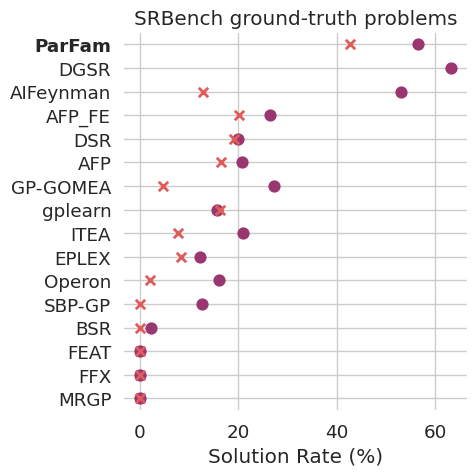

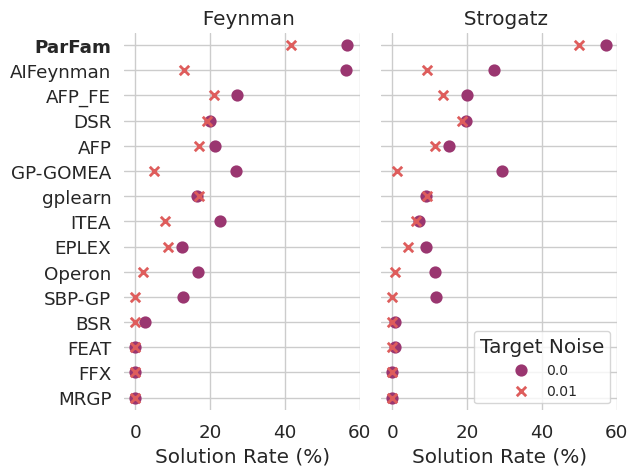

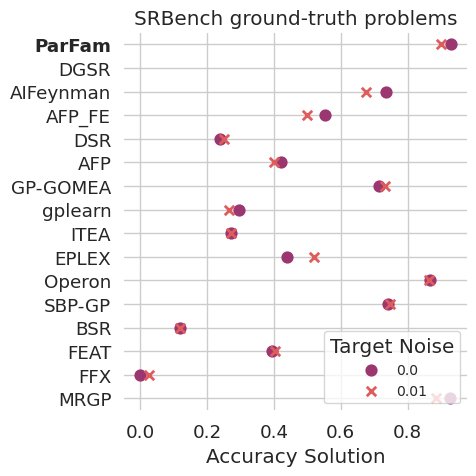

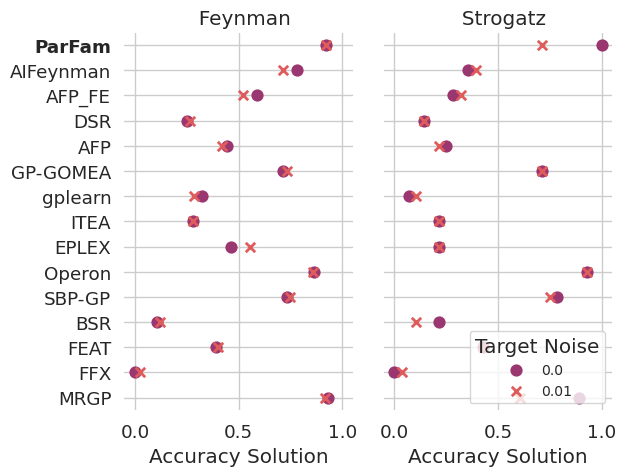

In [32]:
#Calculate on order used for all pirctures
tmp =  df_sum.groupby(['target_noise','algorithm'])['symbolic_solution_rate_(%)'].apply(np.mean).unstack().mean()
order = tmp.sort_values(ascending=False).index.tolist() # Sort values
#Set ParFam to first value of order
order.remove("ParFam")
order = ["ParFam"]+order
order = pd.Index(order,name='algorithm')
#


#'accuracy_solution','r2_test',
for metric in ['symbolic_solution_rate_(%)','accuracy_solution']:
# for metric in ['r2_test']:
    for kind in ['point']: #,'strip']:
        args =dict(df_compare=df_sum, x=metric, est=np.mean, orient='h',
                   kind=kind,order=order) 
        if kind=='point': 
            args['join'] = False 
            args['markers']=['o','x','s','+']
        if metric == 'r2_test':
            args['xlim'] = [0.5, 1]
        var=0
        if metric == 'symbolic_solution_rate_(%)':
            legend = False
        else:
            legend = True   
        compare(**args,
                hue='target_noise', 
                col=None,
                legend=legend
                ) 
        compare(**args, 
                hue='target_noise', 
                col='data_group',
                legend=True
                ) 

In [33]:
# For comparison vs DGSR
(df_sum[(df_sum['algorithm']=='ParFam') & (df_sum['target_noise'] == 0.0)]['r_squared_test'] > 0.99).mean() 

0.9767441860465116

## 4.2 PairGrid

In [34]:
def plot_errorbars_mean(x):
    global var
    confidence_level = 0.95
    # print(len(x))
    
    if (var % 30) >1:
        mean = np.mean(x)
        margin_of_error = 1.96 * np.std(x) / np.sqrt(len(x))  # Calculate the margin of error for a 95% confidence interval
        x1 = mean - margin_of_error
        x2 = mean + margin_of_error
    else:   
        x1 = np.nan
        x2 = np.nan
    var +=1
    return (x1,x2)


#In order to not plot standard deviation for ParFam
def plot_errorbars_median(x):
    global var

    confidence_level = 0.95
    num_bootstrap_samples = 1000
    # print(var)
    # print(f'Length of x: {len(x)}')
    if (var%30==25) | (var%30==26):
        median_ci = (np.nan, np.nan)
    else:
        median_ci = np.percentile(np.median(np.random.choice(x, (num_bootstrap_samples, len(x)), replace=True), axis=1), 
                                  [(1 - confidence_level) / 2 * 100, (1 + confidence_level) / 2 * 100])

        
    var += 1
    return median_ci

def pairgrid(df_plot,x_vars,datagroup="", estimator_str='mean'):
    if datagroup!="":
        df_plot = df_plot[df_plot["data_group"]==datagroup]

    g = sns.PairGrid(df_plot, 
                 x_vars=x_vars,
                 y_vars=['algorithm'],
                 height=6.5, 
                 aspect=0.7,
                 hue='target_noise',
                 palette='flare_r'
#                  hue_order=[0.01,0.001,0]
#                  hue='dataset'
                )
    
    if estimator_str == 'mean':
        estimator = np.mean
    else:
        estimator = np.median
        
    g.map(sns.pointplot, 
          #size=10,
          orient="h",
          #jitter=False,
          order=order,
          palette='flare_r',
          errwidth=2,
          #linewidth=0.01,
          #markeredgecolor='w',
          join=False,
          estimator=estimator,
          n_boot=1000,
          markers=['o','x'],
          scale=1.2,
          errorbar = None # plot_errorbars_median
          #markeralpha=0.5
         )
    if datagroup=="":
        g.fig.suptitle("SRBench ground-truth problems",y=1.02)
    else:
        g.fig.suptitle(datagroup,y=1.02)
    #Set ParFam index to bold on y axis
    subplot_index=0
    y_labels = g.axes[subplot_index, 0].get_yticklabels()
    y_labels[0].set_fontweight('bold')
    g.axes[subplot_index, 0].set_yticklabels(y_labels)

    plt.legend(title='Target Noise')
    titles = [x.replace('_',' ').title().replace('(S)','(s)') for x in x_vars]

    for ax, title in zip(g.axes.flat, titles):

        # remove xlabel
        ax.set_xlabel('')
        ax.set_ylabel('')
        # Set a different title for each axes
        ax.set(title=title)
        if any([n in title.lower() for n in ['size','complexity','time']]):
            ax.set_xscale('log')
        if 'R2' in title and 'Rank' not in title:            
            ax.set(title=title.replace('R2','$R^2$'))
            ax.set_xscale('logit')
            
            if estimator_str == 'mean':
                ax.set_xlim([0.5,0.9999])
                labels = ['0.5', '0.9', '0.99', '0.999', '0.9999']
                ax.set_xticklabels(labels)#, rotation=90)
            else:
                ax.set_xlim([0.5,0.999999999999999])
                labels = ['0.5',r'$1-10^{-3}$',r'$1-10^{-6}$',r'$1-10^{-9}$',r'$1-10^{-12}$',r'$1-10^{-15}$']
                ax.set_xticklabels(labels, rotation=45)
            
        # Make the grid horizontal instead of vertical
        ax.yaxis.grid(True)
        
    
    save(g, 'pairgrid_'+'_'.join(x_vars)+'_'+datagroup+estimator_str)

/home/philipp/anaconda3/envs/srbench/lib/python3.10/site-packages/seaborn/categorical.py:1728: UserWarning: You passed a edgecolor/edgecolors ((0.87199254, 0.3633634, 0.35974223)) for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(x, y, label=hue_level,
/home/philipp/anaconda3/envs/srbench/lib/python3.10/site-packages/seaborn/categorical.py:1728: UserWarning: You passed a edgecolor/edgecolors ((0.87199254, 0.3633634, 0.35974223)) for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(x, y, label=hue_level,
/home/philipp/anaconda3/envs/srbench/lib/python3.10/site-packages/seaborn/categorical.py:1728: UserWarning: You passed a edgecolor/edgecolors ((0.87199254, 0.3633634, 0.35974223)) for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may ch

saving pairgrid_r2_test_model_size_training-time-(s)_mean.pdf


/home/philipp/anaconda3/envs/srbench/lib/python3.10/site-packages/seaborn/categorical.py:1728: UserWarning: You passed a edgecolor/edgecolors ((0.87199254, 0.3633634, 0.35974223)) for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(x, y, label=hue_level,
/home/philipp/anaconda3/envs/srbench/lib/python3.10/site-packages/seaborn/categorical.py:1728: UserWarning: You passed a edgecolor/edgecolors ((0.87199254, 0.3633634, 0.35974223)) for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(x, y, label=hue_level,
/home/philipp/anaconda3/envs/srbench/lib/python3.10/site-packages/seaborn/categorical.py:1728: UserWarning: You passed a edgecolor/edgecolors ((0.87199254, 0.3633634, 0.35974223)) for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may ch

saving pairgrid_r2_test_model_size_training-time-(s)_median.pdf


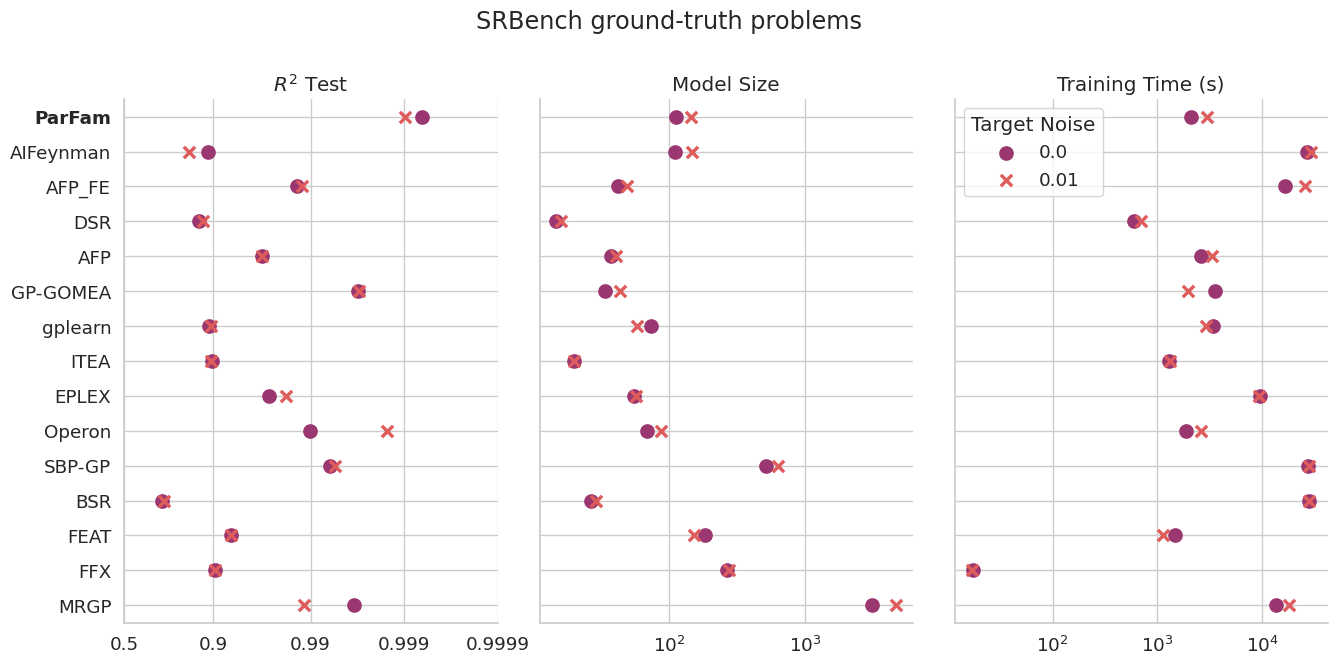

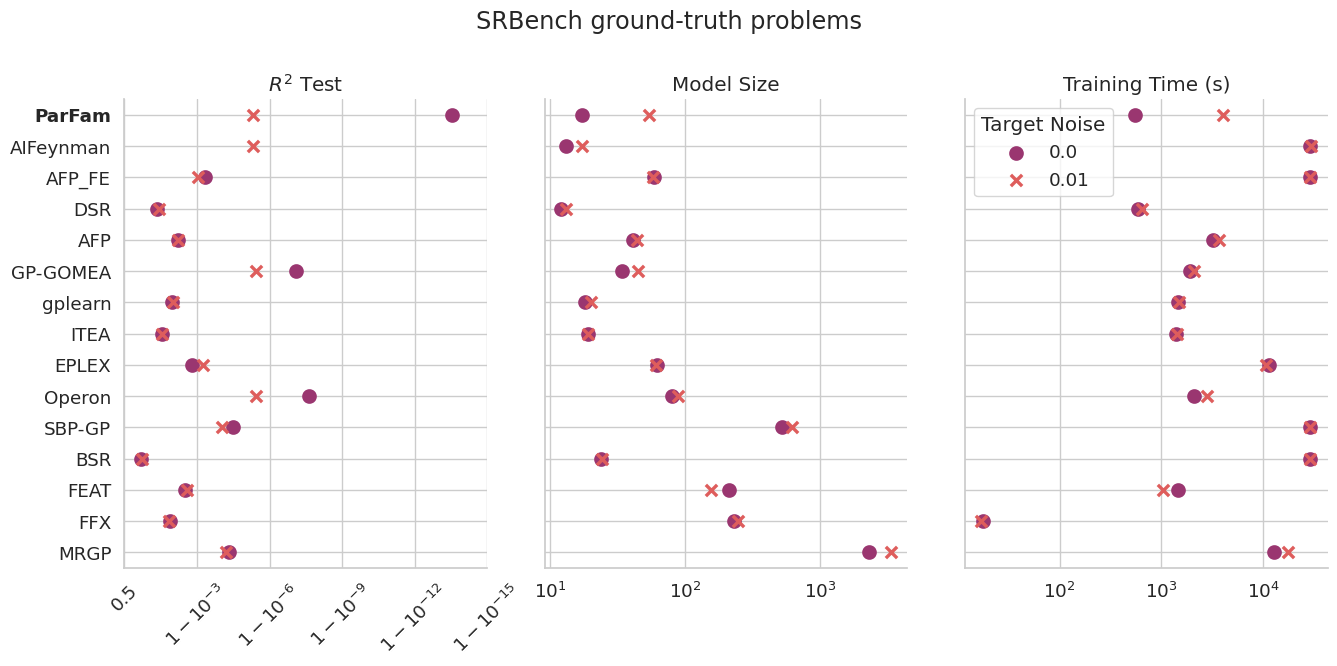

In [35]:
var = 0
# Make the PairGrid
df_plot = df_sum.copy()
tmp = df_plot.groupby(['target_noise','algorithm'])['symbolic_solution_rate'].mean().unstack().mean()
order = tmp.sort_values(ascending=False).index
df_plot['size_diff'] = df_plot['model_size']-df_plot['simplified_complexity']+1
x_vars=[
#         'accuracy_solution_rate_(%)',
#         'mse_test',
#         'r2_test_rank',
#         'r2_test_norm',
        #'symbolic_solution_rate_(%)',
        'r2_test',
        #'simplified_complexity',
#         'size_diff',
        'model_size',
        'training time (s)',
#         'solution'
]

for datagroup in [""]: #,"Feynman","Strogatz"]:
    pairgrid(df_plot,x_vars,datagroup, estimator_str='mean')
    pairgrid(df_plot,x_vars,datagroup, estimator_str='median')


In [36]:
# Why is AIFeynman not visible in the median plot of R²?
df_sum[(df_sum['algorithm'] == 'AIFeynman') & (df_sum['target_noise'] == 0)][['r2_test', 'mse_test']].min()

r2_test     0.000000e+00
mse_test    6.159482e-33
dtype: float64